In [14]:
import numpy as np
import scipy.stats as sp # for calculating standard error
import multiprocessing
from math import cos, exp, pi
from scipy.integrate import quad, quad_vec
from scipy import interpolate
from scipy import integrate
from scipy.special import eval_legendre
from fastpt import FASTPT
import matplotlib
import matplotlib.pyplot as plt
#import camb#/home/u14/gibbins/spherex_emu
#from camb import model
#import pyDOE
#from pyDOE import lhs
import time

#from gpsclass import CalcGalaxyPowerSpec
#from lhc import create_lhs_samples

In [11]:
#Calculates Galaxy PS from Linear PS
class CalcGalaxyPowerSpec:
    def __init__(self,fz,Plin,karray,galaxyBias,cosmoParams):
        #Define linear matter power spectrum and k array generated from CAMB
        self.fz = fz
        self.P_lin  = Plin
        self.k_vec = karray
        
        self.sigv = 450.
        
        #pull out values of cosmology parameters used to generate the linear power spectrum from array
        self.H0, self.omb, self.omc, self.As, self.ns = cosmoParams
        
        #assign values of bias parameters from bias array
        #linear bias, quadratic bias, tidal bias, non-local bias
        self.b1, self.b2, self.bs, self.b3nl = galaxyBias
        
        #computes FASTPT Grid. Needing for following power spectra calculations
        # initialize the FASTPT class
        # including extrapolation to higher and lower k
        self.fastpt=FASTPT(self.k_vec,to_do=['all'],low_extrap=-5,high_extrap=3,n_pad=500)
        
    def get_linear_kaiser(self,x):
        """Calculates the density-density, density-velocity (I call this cross)
           and velocity-velocity power spectra to third order"""
        
        #Define bias values
        #b1 = self.b1
        #b2 = self.b2
        #bs = self.bs
        #b3nl = self.b3nl
        
        ### DENSITY CALCULATION ###
        
        #calls function in FASTPT to compute all necessary components for density ps. stores them in one array
        PXXNL_b1b2bsb3nl_d = self.fastpt.one_loop_dd_bias_b3nl_density(self.P_lin, C_window=.65)
        
        #Breaks up earlier array into individual components
        [one_loopkz_d, Pd1d2_d, Pd2d2_d, Pd1s2_d, Pd2s2_d, Ps2s2_d, sig4kz, sig3nl] = [
                np.outer(1, PXXNL_b1b2bsb3nl_d[0]),
                np.outer(1, PXXNL_b1b2bsb3nl_d[2]),
                np.outer(1, PXXNL_b1b2bsb3nl_d[3]),
                np.outer(1, PXXNL_b1b2bsb3nl_d[4]),
                np.outer(1, PXXNL_b1b2bsb3nl_d[5]),
                np.outer(1, PXXNL_b1b2bsb3nl_d[6]),
                np.outer(1, PXXNL_b1b2bsb3nl_d[7]),
                np.outer(1, PXXNL_b1b2bsb3nl_d[8])]
        
        a=1/(1+.61)
        c=299726.

        #density-density galaxy power spectrum
        Pgg_d = (self.b1**2 * (self.P_lin+one_loopkz_d)
               + self.b1*self.b2*Pd1d2_d + 
               (1./4)*self.b2*self.b2*(Pd2d2_d - 2.*sig4kz)
               + self.b1*self.bs*Pd1s2_d + 
               (1./2)*self.b2*self.bs*(Pd2s2_d - 4./3*sig4kz)
               + (1./4)*self.bs*self.bs*(Ps2s2_d - 8./9*sig4kz) + (self.b1*self.b3nl)*sig3nl)
        
        ### VELOCITY CALCULATION ###
        
        #calls function in FASTPT to compute all necessary components for velocity ps. stores them in one array
        PXXNL_b1b2bsb3nl_v = self.fastpt.one_loop_dd_bias_b3nl_velocity(self.P_lin, C_window=.65)

        #Breaks up earlier arrays into individual components
        #Some are the same as the density calculation. Only new terms are computed here
        [one_loopkz_v, Pd1d2_v, Pd1s2_v] = [
                np.outer(1, PXXNL_b1b2bsb3nl_v[0]),
                np.outer(1, PXXNL_b1b2bsb3nl_v[3]),
                np.outer(1, PXXNL_b1b2bsb3nl_v[4])]
        
        #velocity-velocity galaxy power spectrum
        #need factor of (a*67.*fz/c)**2 to make units work
        Pgg_v = (self.P_lin+(a*self.H0*self.fz/c)**2*one_loopkz_v)
        
        ### CROSS CALCULATION ###
        
        #calls function in FASTPT to compute all necessary components for cross ps. stores them in one array
        PXXNL_b1b2bsb3nl_c = self.fastpt.one_loop_dd_bias_b3nl_cross(self.P_lin, C_window=.65)
        
        #Breaks up earlier arrays into individual components
        #Some are the same as the earlier calculations. Only new terms are computed here
        [one_loopkz_c] = [np.outer(1, PXXNL_b1b2bsb3nl_c[0])]
        
        #density-velocity galaxy power spectrum
        #need factor of (a*67.*fz/c) to make units work
        Pgg_c =  (self.b1*(self.P_lin+(a*self.H0*self.fz/c)*one_loopkz_c) 
                   + (a*self.H0*self.fz/c)*(self.b2*Pd1d2_v + self.bs*Pd1s2_v) 
                   + self.b3nl*sig3nl)
        
        #kaiser = Pgg_d + 2.*f*x**2*Pgg_c + f**2*x**4*Pgg_v
        
        #Combine terms we just calculated to get kaiser term 
        return Pgg_d + 2.*self.fz*x**2*Pgg_c + self.fz**2*x**4*Pgg_v #Pgg_d, Pgg_c, Pgg_v
    
    def get_tns_corrections(self,x):
        """Calculate the TNS correction terms. These account for nonlinearities arising from coupling
           between the density and velocity fields"""
        
        #Here I get the individual terms for the TNS corrections.
        A1, A3, A5, B0, B2, B4, B6, P_Ap1, P_Ap3, P_Ap5 = self.fastpt.RSD_components(self.P_lin, self.fz/self.b1, P_window=None, C_window=0.65)
        
        #These are found in the FAST-PT github under RSD.py
        A_mu2 = self.k_vec*(self.fz/self.b1)*(A1 + P_Ap1)
        A_mu4 = self.k_vec*(self.fz/self.b1)*(A3 + P_Ap3) 
        A_mu6 = self.k_vec*(self.fz/self.b1)*(A5 + P_Ap5)

        B_mu2 = ((self.fz/self.b1)*self.k_vec)**2*B0
        B_mu4 = ((self.fz/self.b1)*self.k_vec)**2*B2
        B_mu6 = ((self.fz/self.b1)*self.k_vec)**2*B4
        B_mu8 = ((self.fz/self.b1)*self.k_vec)**2*B6
        
        #return A_mu2, A_mu4, A_mu6, B_mu2, B_mu4, B_mu6, B_mu8
        return (self.b1**3*A_mu2+self.b1**4*B_mu2)*x**2 + (self.b1**3*A_mu4+self.b1**4*B_mu4)*x**4 + (self.b1**3*A_mu6+self.b1**4*B_mu6)*x**6 + self.b1**4*B_mu8*x**8 
    
    def get_FOG(self,x,sigv):
        """Describes effect of the velocity field on small scale galaxy clustering"""
        
        #FOG term can take different functional forms. Here we choose to use an exponential
        arg = self.fz*x*(self.k_vec/(self.H0/100))*self.sigv/(self.H0)
        
        return np.exp(-.5*arg**2)
    
    def get_integrand(self, x,pole):
        """Integrand needed to perform integral"""
        
        coeff = (2.*pole +1.)/2.
        
        return coeff*eval_legendre(pole,x)*self.get_FOG(x,self.sigv)*(self.get_linear_kaiser(x)+self.get_tns_corrections(x))
    
    def get_nonlinear_ps(self,pole):
        
        result = np.zeros((1,len(self.k_vec)))
        
        #def get_integrand(self, x):
        #    """Integrand needed to perform integral"""
        
        #    coeff = (2.*pole +1.)/2.
        
        #    return coeff*eval_legendre(pole,x)*self.get_FOG(x,self.sigv)*(self.get_linear_kaiser(x)+self.get_tns_corrections(x))

        
        result[0,:], error = integrate.quad_vec(self.get_integrand, -1, 1,args=(pole,))
            
        return result

### For Tracer1 auto spectra

In [34]:
ps = np.load('/Users/anniemoore/desktop/out.npz')


In [35]:
print(ps.files)

mono_test = ps['psm']
quad_test = ps['psq']

['params', 'psm', 'psq']


In [37]:
print(mono_test)

[[ 147.62362013  284.41508553  545.89022397 1039.31366166 1942.5983558
  3488.75732671 5673.27026085 7113.53479143 4187.55684958  340.28571521]]


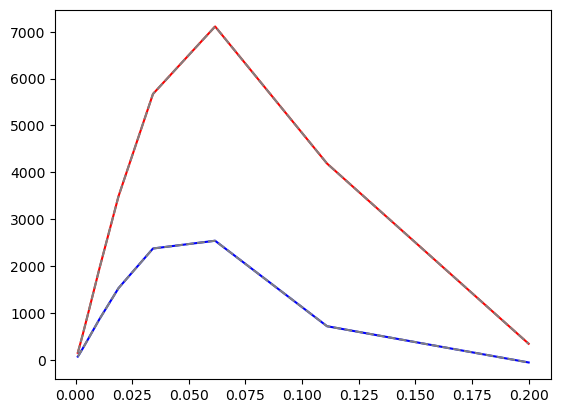

In [39]:
#array([6.22954856e+01, 5.88608308e-01, 1.78577808e-01, 2.01059374e-09,
 #      1.11635806e+00]), 
k= np.array([0.001     , 0.00180165, 0.00324594, 0.00584804, 0.0105361 ,
       0.01898235, 0.03419952, 0.0616155 , 0.11100946, 0.2       ])
mono = np.array([ 147.62361742,  284.41508111,  545.89021707, 1039.31365139,
       1942.59834222, 3488.75731165, 5673.27025113, 7113.53467377,
       4187.55688335,  340.28594947])
quad = np.array([  65.97793396,  127.03926337,  243.74146396,  463.52766154,
        862.92941065, 1527.48045941, 2373.92278274, 2539.42212577,
        714.65097596,  -59.32596458])

# array([ 147.62362013,  284.41508553,  545.89022397, 1039.31366166,
#        1942.5983558 , 3488.75732671, 5673.27026085, 7113.53479143,
#        4187.55684958,  340.28571521]), array([  65.97793517,  127.03926534,  243.74146705,  463.52766613,
#         862.92941678, 1527.48046612, 2373.92278643, 2539.42214633,
#         714.65097507,  -59.32586196]))

plt.plot(k,mono,color='red')
plt.plot(k,mono_test[0],linestyle='--',color='gray')
plt.plot(k,quad,color='blue')
plt.plot(k,quad_test[0],linestyle='--',color='gray')

In [ ]:
array([3.94649938e+01, 9.02874360e-01, 2.44894201e-01, 2.12798316e-09,
       1.05033112e+00])

### For Tracer 2 auto spectra

In [41]:
ps = np.load('/Users/anniemoore/desktop/out.npz')

In [44]:
mono_test_t2 = ps['psm']
quad_test_t2 = ps['psq']

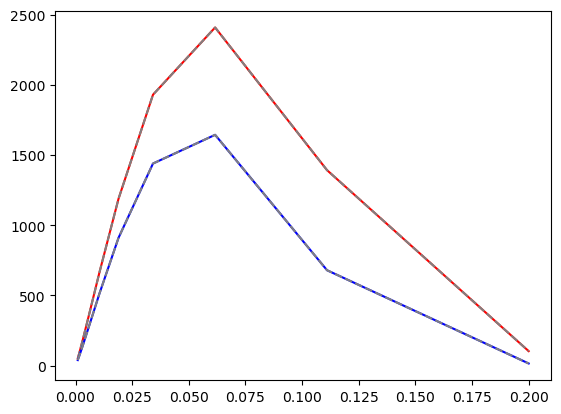

In [45]:
mono_t2 = np.array([  50.27349806,   96.85396094,  185.89966144,  353.943439  ,
        661.54395143, 1187.55482342, 1928.90117989, 2407.64717417,
       1391.55415725,  102.82964111])
quad_t2 = np.array([  38.98875121,   75.07867857,  144.0750479 ,  274.14183524,
        511.20553426,  909.57796708, 1438.68685159, 1643.19547282,
        678.97874348,   14.97203928])

plt.plot(k,mono_t2,color='red')
plt.plot(k,mono_test_t2[0],linestyle='--',color='gray')
plt.plot(k,quad_t2,color='blue')
plt.plot(k,quad_test_t2[0],linestyle='--',color='gray')

### Cross power spectra

In [46]:
ps_cross = np.load('/Users/anniemoore/desktop/out.npz')

In [48]:
mono_test_cross = ps['psm']
quad_test_cross = ps['psq']

In [49]:
print(mono_test_cross)

[[  50.27349806   96.85396094  185.89966144  353.943439    661.54395143
  1187.55482342 1928.90117989 2407.64717417 1391.55415725  102.82964111]]
